In [4]:
import sys
sys.path.append('..')
import deep_control as dc

import numpy as np

import pickle

In [5]:
from tqdm import tqdm

In [6]:
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline

sns.set_style("whitegrid")
sns.set_context("talk")
sns.set_style("ticks", {"xtick.major.size": 4, "ytick.major.size": 4})


In [10]:
model_th = dc.nn.load_model('nets/rw/0/ReLu_outputLog_3_32.model')
network_th = dc.nn.load_network(model_th, base_dir='')

model_dth = dc.nn.load_model('nets/rw/1/ReLu_outputLog_3_32.model')
network_dth = dc.nn.load_network(model_dth, base_dir= '')


In [11]:
networks = [(model_th, network_th),
            (model_dth, network_dth)]

In [13]:
data = dc.nn.load_training_data(model_th, '')

In [67]:
batch= 1000

errors = []
for dset in ['train', 'test']:

    for i,(model,network) in enumerate(networks):

        error = []    
        for b in tqdm(range(int(0.01*data['X_'+dset].shape[0]/batch)), dset + ' set, network ' + str(i) , leave=True):
            u = np.zeros((batch,len(networks)))
            network_input = data['X_'+dset][b*batch:(b+1)*batch,:]
           # network_input = dc.nn.preprocess(model, network_input)
            ui = network['pred'](network_input) 
            u[:,i] = ui[:,0]

            u = dc.nn.postprocess(model, u)
            u_gt = data['Y_'+dset][b*batch:(b+1)*batch,:].copy()        
            u_gt = dc.nn.postprocess(model, u_gt)        
            error.append((np.abs(u[:,i] - u_gt[:,i])).mean())
        errors.append((i,dset,np.mean(error)))

for (net, dset, err) in errors:
    print('u{0} {1} error {2}'.format(net,dset, err))



test set, network 1: 100%|██████████| 14/14 [00:00<00:00, 45.14it/s]

u0 train error 871.9085110742557
u1 train error 0.0023533229801505134
u0 test error 948.3010438317713
u1 test error 0.002202270633490543


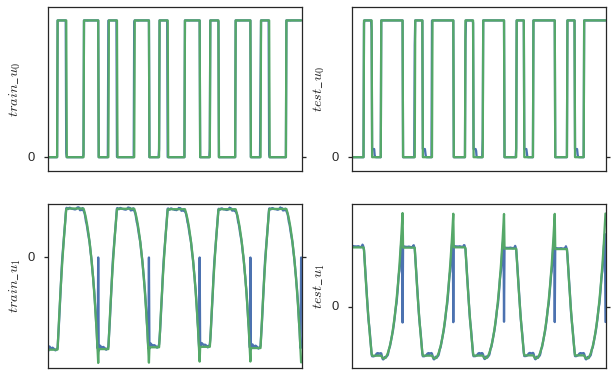

In [14]:
plt.rcParams['figure.figsize'] = [10,10]

batch = 500
b = 0#Index

for s, dset in enumerate(['train', 'test']):

    for i,(model,network) in enumerate(networks):

        plt.subplot(3, 2, i*2+s+1)
        u = np.zeros((batch,len(networks)))
        network_input = data['X_'+dset][b*batch:(b+1)*batch,:]
     #   network_input = dc.nn.preprocess(model, network_input)
        ui = network['pred'](network_input) 
        u[:,i] = ui[:,0]

        u = dc.nn.postprocess(model, u)
        u_gt = data['Y_'+dset][b*batch:(b+1)*batch,:].copy()        
        u_gt = dc.nn.postprocess(model, u_gt)        
        plt.plot(u[:,i])
        plt.plot(u_gt[:,i])
        
        plt.locator_params(axis='y', nbins=1)
        plt.gca().get_xaxis().set_ticks([])
        plt.ylabel(r'$' + dset+ '\_u_'+str(i)+'$')
            
        plt.ylim((min(u_gt[:,i])-max(u_gt[:,i])*0.1,max(u_gt[:,i])+max(u_gt[:,i])*0.1))

        

In [59]:
import glob
import pickle
from tqdm import tqdm
import pandas

files = glob.glob('../data/rw/*pic')
col_names = ['t', 'x', 'y', 'z', 'vz', 'theta', 'm', 'u1', 'u2']
total = 0
trajs = []
for f in tqdm(files[:10], leave=True):    
        rw = pickle.load(open(f,'rb'))
        rwi = rw[0]
        traj = np.hstack((rwi[0], rwi[1]))
        df = pandas.DataFrame(data=traj)
        
        df.columns = col_names
        trajs.append(df)


100%|██████████| 10/10 [00:00<00:00, 247.64it/s]


In [24]:
training_cols = [1,2,3,4,5,6]

In [60]:
from math import sin,cos

R = 3
g = 1.6229
g0 = 9.81
isp = 311

def compute_control(state, networks):
    u = []
    for (model, network) in networks:
        network_input = state[[0,1,2,3,4,5]]
        network_input = dc.nn.preprocess(model, network_input)
        ui = network['pred'](network_input.reshape(1,-1))[0,0]    
        u.append(ui)
        
    u = np.asarray(u).reshape(1,-1)
    u = dc.nn.postprocess(model, u)[0]
    
    return u



#state is [mass, x, vx, z, vz, theta, vtheta, thrust, thrust_left, thrust_right
#networks is [(model_thrust, network_thrust),
#             (model_thrust_left, network_thrust_left),
#             (model_thrust_right, network_thrust_right)]

def dy(state, t, networks, compute_control):
    
    m = state[0]
    vx = state[2]
    vz = state[4]
    theta = state[5]
     
    u = compute_control(state,networks)
    
    d_m = -(u[0]) / (isp*g0);
    d_x = vx
    d_vx = u[0] * sin(theta) / m
    d_z = vz
    d_vz = u[0] * cos(theta) / m - g  
    d_theta = u[1]

    ds = np.array([d_m, d_x, d_vx, d_z, d_vz, d_theta])               
    return ds

def final_check(state):
    if state[1] < 0:
        return 'crash'
    if state[1] < 10 and abs(state[2]) < 1 and abs(state[3]) < 1:
        return 'done'
    return None

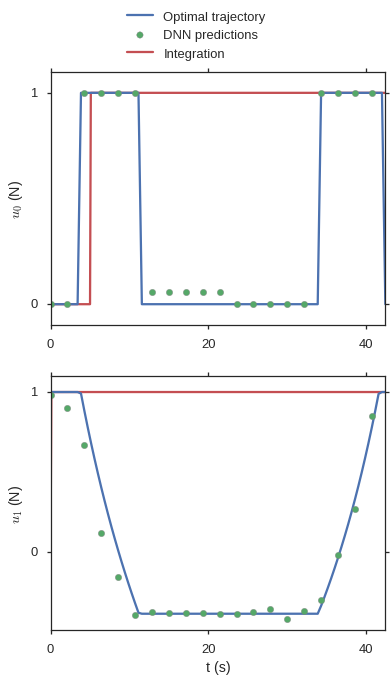

In [61]:
show = 8
show_vars = [0,1]
units = ['N', 'N']
control_vars = ['u1', 'u2']

plt.rcParams['figure.figsize'] = (6, len(show_vars)*5)
sns.set_context(font_scale=1.5)

initial_pos = trajs[show].values[0,1:-2].copy()

nn_traj = dc.integrate.integrate_landing(dy, networks, compute_control, initial_pos, final_check,
                                             col_names=col_names, max_time =100, dt=0.1 )[0]

for n in show_vars:
    
    plt.subplot(len(show_vars),1,n+1)
    
    (model, network) = networks[n]

    input_data = trajs[show].values[:,training_cols]
    t = trajs[show].values[:,0]
    gt_u = trajs[show].values[:,-2+n]

    input_data = dc.nn.preprocess(model_th, input_data)


    (model, network) = networks[n]
    u = np.zeros((len(input_data),len(networks)))
    ui = network['pred'](input_data) 
    u[:,n] = ui[:,0]
    u = dc.nn.postprocess(model, u)

    label1, = plt.plot(t,gt_u, zorder =0)
    scatter_n = 20
    scatter_selected = list(range(0,len(t), int(len(t)/scatter_n)))
    label2  = plt.scatter(t[scatter_selected], u[scatter_selected,n],  c=sns.color_palette()[1],
                              zorder=2, edgecolors='gray', s=40)
    label3, = plt.plot(nn_traj['t'],nn_traj[control_vars[n]], c=sns.color_palette()[2], zorder =-2)      

    plt.locator_params(axis='y', nbins=3)
    plt.locator_params(axis='x', nbins=3)
    plt.xlim((0,t[-1]))
    plt.ylim((min(gt_u)-max(gt_u)*0.1,max(gt_u)+max(gt_u)*0.1))
    
    xlabel = 't (s)' if n == show_vars[-1] else ''

    sns.axlabel(xlabel, r'$u_'+str(n)+'$ (' + units[n] +') ')
    
plt.figlegend([label1,label2,label3], ['Optimal trajectory', 'DNN predictions', 'Integration'], loc='upper center')

    #fig.savefig('imgs/optimal_preds_control.png', bbox_inches='tight')


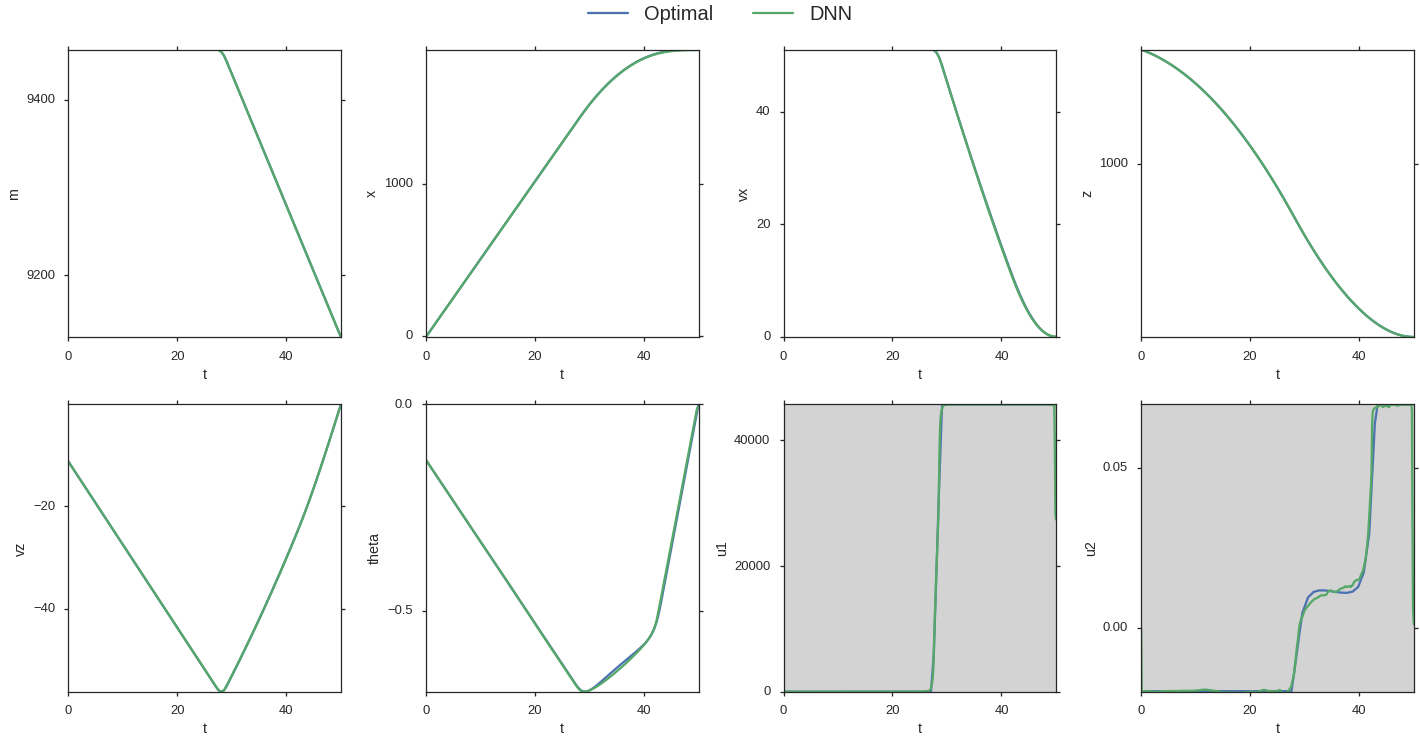

In [198]:
fig = dc.vis.compare_control(trajs[show], nn_traj, 2)
fig.savefig('mass_thruster_dtheta_all.pdf', bbox_inches='tight')

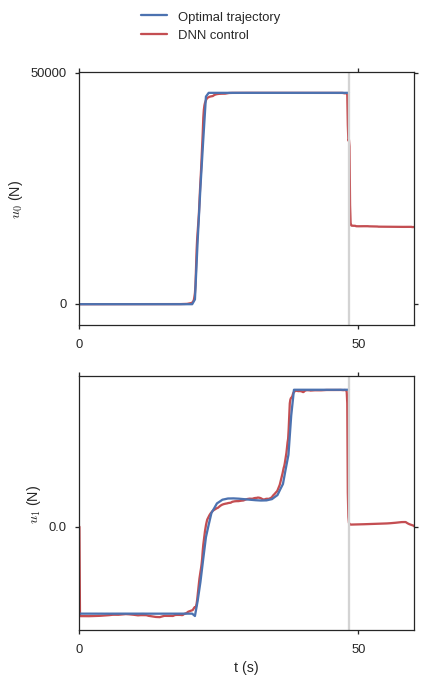

In [99]:
show_vars = [0,1]

plt.rcParams['figure.figsize'] = (6, len(show_vars)*5)

#show = 58
show = 11
for n in show_vars:
    
    plt.subplot(len(show_vars),1,n+1)
    
    (model, network) = networks[n]

    input_data = trajs[show].values[:,training_cols]
    t = trajs[show].values[:,0]
    gt_u = trajs[show].values[:,-2+n]

    initial_pos = trajs[show].values[0,1:-2]
    nn_traj = dc.integrate.integrate_landing(dy, networks, compute_control, initial_pos, final_check,
                                             stop_if_crash=False, stop_if_done=False, col_names=col_names,
                                             max_time =60, dt=0.1, )[0]

    
    label1, = plt.plot(t,gt_u, zorder =0)
    label3, = plt.plot(nn_traj['t'],nn_traj[control_vars[n]], c=sns.color_palette()[2], zorder =-2)
        
    plt.locator_params(axis='y', nbins=3)
    plt.locator_params(axis='x', nbins=3)
    plt.xlim((0, nn_traj.values[-1, 0]))
    plt.ylim((min(gt_u)-max(gt_u)*0.1,max(gt_u)+max(gt_u)*0.1))

    xlabel = 't (s)' if n == show_vars[-1] else ''

    sns.axlabel(xlabel, r'$u_'+str(n)+'$ (' + units[n] +') ')
    plt.vlines([t[-1]],plt.ylim()[0], plt.ylim()[1],color='lightgray')
    
plt.figlegend([label1,label3], ['Optimal trajectory',  'DNN control'], loc = 'upper center', ncol=1)

    #fig.savefig('imgs/optimal_preds_control.png', bbox_inches='tight')


In [150]:
from math import pi

def evaluate_optimality(networks, params, n, col_names, dy, final_check):
    samples = []
    while len(samples) < n:
        found = False
        conditions = {}
        initial_pos = []
        for key, value_range in params:
            conditions[key] = value_range[0] + (value_range[1]-value_range[0])*np.random.rand()
            initial_pos.append(conditions[key])
        
        traj = dc.data.get_trajectory('../SpaceAMPL/lander/hs/main_rw_mass.mod', conditions, col_names=col_names)
        if traj is not None:            
            print(initial_pos)
            
            nn_traj, check = dc.integrate.integrate_landing(dy, networks, compute_control,initial_pos, final_check,
                                                    stop_if_crash=False, stop_if_done=False, col_names=col_names, 
                                                    max_time =100, dt=0.1, )            
            samples.append({'initial_pos':initial_pos, 'nn_traj' : nn_traj, 'opt_traj' : traj, 'check': check})
        return samples
        

In [72]:
def error_mass(opt, pred):
    goal =  pred['m'].iloc[0] - pred['m'].iloc[-1]
    optimal_goal =  opt['m'].iloc[0] - opt['m'].iloc[-1]
    error = (goal - optimal_goal)/optimal_goal
    return abs(error)

In [172]:
params = [('m0', (8000,12000)),
          ('x0', (-1000,1000)),
          ('vx0', (-100,100)),          
          ('z0', (500,2000)),
          ('vz0', (-30,10)),
          ('theta0', (-np.pi/20,np.pi/20))]


In [173]:
samples = evaluate_optimality(networks, params, 10, col_names, dy, final_check)

[9415.81565629635, 79.19302663643634, -63.65310997562486, 1086.150182304621, -13.72293082948094, 0.05194453701009885]


In [174]:
errors = []
crash = 0
for s in samples:
    if s['check'] == 'crash':
        crash +=1
    else:
        errors.append(error_mass(s['opt_traj'], s['nn_traj']))
                                  
print('Mass, relative error', np.mean(errors), ',computed from', len(errors), ' trajectories')
print('Crash rate: ', crash/len(samples)*100, '%')

Mass, relative error 0.887063796454 ,computed from 1  trajectories
Crash rate:  0.0 %


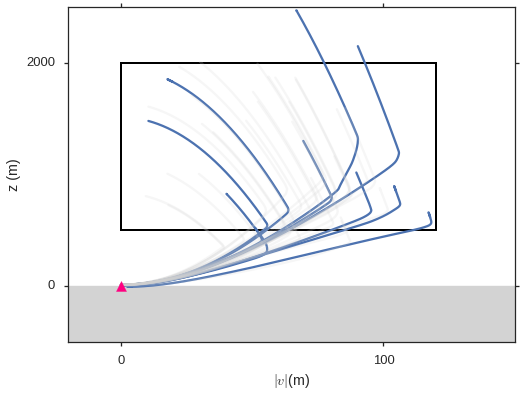

In [124]:
plt.rcParams['figure.figsize'] = (8,6)
from math import sqrt
fig = plt.figure()
ax = plt.axes(xlim=(-20,150), ylim=(-500, 2500))

ground = plt.Rectangle([-1500,-500],3000,500,color='lightgray')
training_area = plt.Rectangle([0,500],120,1500,facecolor='white',edgecolor='black',linewidth=2)
ax.add_patch(ground)
ax.add_patch(training_area)

for zi,vxi,vzi in zip(z,vx,vz):
    initial_pos = np.asarray([10000, 0, vxi, zi, vzi, 0])
    nn_traj, check = dc.integrate.integrate_landing(dy, networks, compute_control,initial_pos, final_check,
                                                    stop_if_crash=False, stop_if_done=False, col_names=col_names, 
                                                    max_time =100, dt=0.1, )
    plt.plot(np.sqrt((nn_traj['vz']**2+nn_traj['vx']**2)), nn_traj['z'], color=sns.color_palette()[0])


gt_traj, = plt.plot(np.sqrt((trajs[0]['vz']**2+trajs[0]['vx']**2)), trajs[0]['z'] , color='gray', alpha = 0)
for t in trajs[1:500]:
    plt.plot(np.sqrt((t['vz']**2+t['vx']**2)), t['z'], color='lightgray', alpha = 0.2)
        
goal = plt.scatter(0,0.1,s=100,zorder=10, color=[1,0,0.5], marker='^')    

plt.ylabel('z (m)')
plt.xlabel(r'$|v|$' + '(m)')
    
plt.locator_params(axis='y', nbins=3)
plt.locator_params(axis='x', nbins=3)
